<a href="https://colab.research.google.com/github/KatiaArruda/Classificacao_de_Gatos_e_Cachorros_com_Transfer_Learning_VGG16/blob/main/Classificacao_de_Gatos_e_Cachorros_com_Transfer_Learning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Download the dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/cats-and-dogs-image-classification")

print("Path to dataset files:", path)


100%|██████████| 64.4M/64.4M [00:00<00:00, 79.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/cats-and-dogs-image-classification/versions/4


In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [19]:
# Image directory (use the 'train' training directory)
dataset_dir = "/root/.cache/kagglehub/datasets/samuelcortinhas/cats-and-dogs-image-classification/versions/4/train"
classes = ["cats", "dogs"]

In [20]:
# Create list of images and labels (only 50 images per class)
data = []
for label, category in enumerate(classes):
    category_path = os.path.join(dataset_dir, category)
    if os.path.exists(category_path):
        images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(".jpg")]
        images = random.sample(images, min(len(images), 50))  # Select up to 50 random images
        for img_path in images:
            img = load_img(img_path, target_size=(224, 224))  # Resize to 224x224
            img_array = img_to_array(img) / 255.0  # Normalize
            data.append((img_array, label))
    else:
        print(f"Error: Directory'{category_path}' not found.")

In [21]:
# Shuffle the dice
random.shuffle(data)

In [22]:
# Separate images and labels
X, y = zip(*data)
X = np.array(X)
y = to_categorical(y, num_classes=2)  # Convert to one-hot encoding

In [23]:
# Split into training (70%), validation (15%) and test (15%)
split_train = int(0.7 * len(X))
split_val = int(0.85 * len(X))

X_train, y_train = X[:split_train], y[:split_train]
X_val, y_val = X[split_train:split_val], y[split_train:split_val]
X_test, y_test = X[split_val:], y[split_val:]

print(f"Training: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

Treinamento: 70 | Validação: 15 | Teste: 15


In [25]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Freeze the original model layers
for layer in base_model.layers:
    layer.trainable = False

In [27]:
# Add custom layers to the new task
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dense(2, activation="softmax")(x)  #Two classes: cats and dogs

In [28]:
# Create the new model
model = Model(inputs=base_model.input, outputs=x)

In [29]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [30]:
# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 65s 13s/step - accuracy: 0.3950 - loss: 6.6656 - val_accuracy: 0.4667 - val_loss: 2.5101
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 72s 11s/step - accuracy: 0.5455 - loss: 1.7710 - val_accuracy: 0.5333 - val_loss: 0.7716
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 11s/step - accuracy: 0.6054 - loss: 0.8162 - val_accuracy: 0.5333 - val_loss: 0.9127
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 11s/step - accuracy: 0.7176 - loss: 0.4517 - val_accuracy: 0.5333 - val_loss: 1.0762
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 11s/step - accuracy: 0.7922 - loss: 0.3230 - val_accuracy: 0.6000 - val_loss: 0.6800
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.9792 - loss: 0.1450 - val_accuracy: 0.6000 - val_loss: 0.6666
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step - accuracy: 0.9735 - loss: 0.1245 - val_accuracy: 0.6667 - val_loss: 0.7506
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 11s/step - accuracy: 0.9952 - loss: 0.0756 - val_accuracy: 0.6667 - val_loss: 0.7959


In [31]:
# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7333 - loss: 0.4788
Test Accuracy: 0.73


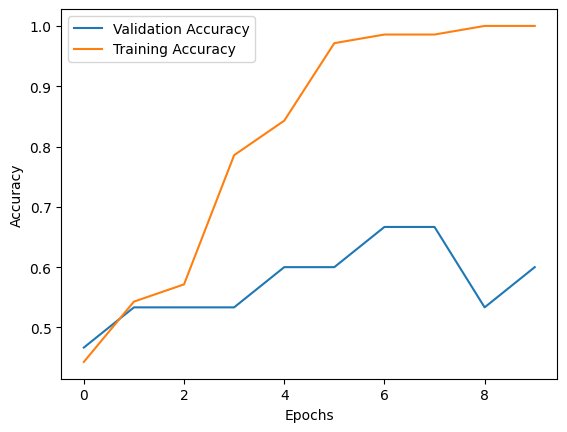

In [32]:
# Plot training history
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()